In [2]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
from sklearn.decomposition import PCA, KernelPCA

# S1 = pfb.weights_model1
# S2 = pfb.weights_model2
# S = np.vstack([S1, S2])
# psa = PCA(n_components=2)
# psa.fit(S)
# xs = psa.transform(S1)
# xt = psa.transform(S2)
# n = len(pfb.weights_model1) # nb samples

# a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# # loss matrix
# M = ot.dist(pfb.weights_model1, pfb.weights_model2)
# M /= M.max()

# pl.figure(1)
# pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
# pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
# pl.legend(loc=0)
# pl.title('Source and target distributions')

# pl.figure(2)
# pl.imshow(M, interpolation='nearest')
# pl.title('Cost matrix M')

# G0 = ot.emd(a, b, M)

# pl.figure(3)
# pl.imshow(G0, interpolation='nearest')
# pl.title('OT matrix G0')

# pl.figure(4)
# ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1])
# pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
# pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')

# pl.legend(loc=0)
# pl.title('OT matrix with samples')

In [12]:
time = np.linspace(0, 6, 61)
time

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1,
       5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. ])

In [2]:
from point_finders import *

getting loaders
Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified
getting data


In [3]:
import models
model_name = 'LinearOneLayer'
architecture = getattr(models, 'LinearOneLayerCF') #LinearOneLayer LogRegression

In [4]:
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model1.load_state_dict(torch.load('curves/'+model_name+'/curve3/checkpoint-400.pt')['model_state'])
model2.load_state_dict(torch.load('curves/'+model_name+'/curve4/checkpoint-400.pt')['model_state'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
model1.cuda();
test_model(model1, loaders, cuda=True)

train results {'nll': 1.0174902257919312, 'loss': 1.0174902257919312, 'accuracy': 66.138}
test results {'nll': 1.3227679414749145, 'loss': 1.3227679414749145, 'accuracy': 59.11}


({'nll': 1.0174902257919312, 'loss': 1.0174902257919312, 'accuracy': 66.138},
 {'nll': 1.3227679414749145, 'loss': 1.3227679414749145, 'accuracy': 59.11})

In [6]:
model2.cuda();
test_model(model2, loaders, cuda=True)

train results {'nll': 1.0161726474761963, 'loss': 1.0161726474761963, 'accuracy': 66.368}
test results {'nll': 1.3180574544906616, 'loss': 1.3180574544906616, 'accuracy': 59.4}


({'nll': 1.0161726474761963, 'loss': 1.0161726474761963, 'accuracy': 66.368},
 {'nll': 1.3180574544906616, 'loss': 1.3180574544906616, 'accuracy': 59.4})

In [7]:
depth = 2

In [8]:
# N_data = 10 #6144
# data, targ = data[:N_data], targ[:N_data]

In [9]:
get_end_point_stat(architecture, model_name, end_ind=3)

 50%|█████     | 1/2 [00:06<00:06,  6.79s/it]

train results {'nll': 1.0152977523994446, 'loss': 1.0152977523994446, 'accuracy': 66.098}
test results {'nll': 1.3088677494049072, 'loss': 1.3088677494049072, 'accuracy': 58.83}


100%|██████████| 2/2 [00:13<00:00,  6.81s/it]

train results {'nll': 1.0116068117141723, 'loss': 1.0116068117141723, 'accuracy': 66.19}
test results {'nll': 1.298913423347473, 'loss': 1.298913423347473, 'accuracy': 59.53}


{'train': [66.098, 66.19], 'test': [58.83, 59.53]}

In [10]:
def test_zeroing(pointfinder, model_name, architecture, beg_ind=1, end_ind=7):
    stat = {'test': [], 'train': []}
    model1 = architecture.base(num_classes=10, **architecture.kwargs)
    model2 = architecture.base(num_classes=10, **architecture.kwargs)
    for i in tqdm(range(beg_ind, end_ind)):
        model1.load_state_dict(torch.load('curves/'+model_name+'/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
        model2.load_state_dict(torch.load('curves/'+model_name+'/curve'+str(i+1)+'/checkpoint-400.pt')['model_state'])
        finder = pointfinder(model1, model2, architecture)
        point = finder.test_zeroing()
        stat['test'].append(point['test'])
        stat['train'].append(point['train'])
    return stat

In [11]:
class PointFinderTransportation(PointFinderWithBias):
    def __init__(self, model1, model2, architecture):
        super().__init__(model1, model2, architecture)
        self.solve_optimal_transport_problem()
        # find bijection
        self.indices = np.argmax(self.G0, axis=-1)
        self.weights_model2_permuted = self.weights_model2[self.indices]
        
    def solve_optimal_transport_problem(self, ):
        self.n = len(self.weights_model1) 
        self.a, self.b = np.ones((self.n,)) / self.n, np.ones((self.n,)) / self.n  # uniform distribution on samples
        # loss matrix
        self.M = ot.dist(self.weights_model1, self.weights_model2)
        self.M /= self.M.max()
        self.G0 = ot.emd(self.a, self.b, self.M)
        
    def find_point(self, t, method='arc_connect'):
        assert 0 <= t <= 1, 't must be between 0 and 1'
        weights_model_new = getattr(Connector( self.weights_model1, self.weights_model2_permuted), method)(t=t)[1]
        B = self.get_b(self.model1, self.model2)
        B = getattr(Connector(B[:1], B[1:]), method)(t=t)[1]
        m = self.get_model_from_weights(weights_model_new, B[0], self.architecture)
        m.cuda();
        res = test_model(m, loaders, cuda=True)
        out = {'train': res[0]['accuracy'], 'test': res[1]['accuracy']}
        return out

    def test_zeroing(self, ):
        weights_model_new = self.weights_model2
        weights_model_new[0] = 0
        B = self.get_b(self.model1, self.model2)
        m = self.get_model_from_weights(weights_model_new, B[1], self.architecture)
        m.cuda();
        res = test_model(m, loaders, cuda=True)
        out = {'train': res[0]['accuracy'], 'test': res[1]['accuracy']}
        return out

In [12]:
time = np.linspace(0, 1, 21)
time

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [13]:
pfb = PointFinderTransportation(model1, model2, architecture)

In [14]:
path_trl = find_path(time, pfb, method='lin_connect')

  5%|▍         | 1/21 [00:06<02:09,  6.49s/it]

train results {'nll': 1.0174902257919312, 'loss': 1.0174902257919312, 'accuracy': 66.138}
test results {'nll': 1.3227679414749145, 'loss': 1.3227679414749145, 'accuracy': 59.11}


 10%|▉         | 2/21 [00:13<02:03,  6.52s/it]

train results {'nll': 1.0143012914848328, 'loss': 1.0143012914848328, 'accuracy': 66.102}
test results {'nll': 1.308853053855896, 'loss': 1.308853053855896, 'accuracy': 59.26}


 14%|█▍        | 3/21 [00:19<01:57,  6.54s/it]

train results {'nll': 1.0203724909973144, 'loss': 1.0203724909973144, 'accuracy': 65.78}
test results {'nll': 1.3053661870956421, 'loss': 1.3053661870956421, 'accuracy': 59.28}


 19%|█▉        | 4/21 [00:26<01:50,  6.53s/it]

train results {'nll': 1.0330255899810792, 'loss': 1.0330255899810792, 'accuracy': 65.334}
test results {'nll': 1.3094146203994752, 'loss': 1.3094146203994752, 'accuracy': 58.9}


 24%|██▍       | 5/21 [00:32<01:44,  6.50s/it]

train results {'nll': 1.0501033125305175, 'loss': 1.0501033125305175, 'accuracy': 64.832}
test results {'nll': 1.3187207542419435, 'loss': 1.3187207542419435, 'accuracy': 58.66}


 29%|██▊       | 6/21 [00:39<01:37,  6.50s/it]

train results {'nll': 1.0691858417510987, 'loss': 1.0691858417510987, 'accuracy': 64.266}
test results {'nll': 1.3308039266586305, 'loss': 1.3308039266586305, 'accuracy': 58.27}


 33%|███▎      | 7/21 [00:45<01:30,  6.50s/it]

train results {'nll': 1.0882029586029052, 'loss': 1.0882029586029052, 'accuracy': 63.656}
test results {'nll': 1.3433777755737304, 'loss': 1.3433777755737304, 'accuracy': 57.95}


 38%|███▊      | 8/21 [00:52<01:24,  6.49s/it]

train results {'nll': 1.1051409468460083, 'loss': 1.1051409468460083, 'accuracy': 63.192}
test results {'nll': 1.3551846061706543, 'loss': 1.3551846061706543, 'accuracy': 57.53}


 43%|████▎     | 9/21 [00:58<01:17,  6.49s/it]

train results {'nll': 1.1182800593948363, 'loss': 1.1182800593948363, 'accuracy': 62.966}
test results {'nll': 1.3646840448379516, 'loss': 1.3646840448379516, 'accuracy': 57.3}


 48%|████▊     | 10/21 [01:05<01:11,  6.51s/it]

train results {'nll': 1.1265136800003053, 'loss': 1.1265136800003053, 'accuracy': 62.754}
test results {'nll': 1.3707005571365356, 'loss': 1.3707005571365356, 'accuracy': 57.25}


 52%|█████▏    | 11/21 [01:11<01:04,  6.49s/it]

train results {'nll': 1.1288891778945922, 'loss': 1.1288891778945922, 'accuracy': 62.738}
test results {'nll': 1.3723571796417235, 'loss': 1.3723571796417235, 'accuracy': 57.25}


 57%|█████▋    | 12/21 [01:18<00:58,  6.48s/it]

train results {'nll': 1.1252309465408326, 'loss': 1.1252309465408326, 'accuracy': 62.858}
test results {'nll': 1.3693527324676513, 'loss': 1.3693527324676513, 'accuracy': 57.59}


 62%|██████▏   | 13/21 [01:24<00:52,  6.50s/it]

train results {'nll': 1.1159273124694824, 'loss': 1.1159273124694824, 'accuracy': 63.112}
test results {'nll': 1.3620014686584472, 'loss': 1.3620014686584472, 'accuracy': 57.79}


 67%|██████▋   | 14/21 [01:31<00:45,  6.49s/it]

train results {'nll': 1.1019613330841065, 'loss': 1.1019613330841065, 'accuracy': 63.584}
test results {'nll': 1.3509989376068114, 'loss': 1.3509989376068114, 'accuracy': 58.09}


 71%|███████▏  | 15/21 [01:37<00:39,  6.52s/it]

train results {'nll': 1.0844270083236693, 'loss': 1.0844270083236693, 'accuracy': 64.074}
test results {'nll': 1.338171683883667, 'loss': 1.338171683883667, 'accuracy': 58.22}


 76%|███████▌  | 16/21 [01:44<00:32,  6.55s/it]

train results {'nll': 1.0650962979507446, 'loss': 1.0650962979507446, 'accuracy': 64.556}
test results {'nll': 1.3246959976196289, 'loss': 1.3246959976196289, 'accuracy': 58.61}


 81%|████████  | 17/21 [01:50<00:26,  6.56s/it]

train results {'nll': 1.0458180412292482, 'loss': 1.0458180412292482, 'accuracy': 65.044}
test results {'nll': 1.3122183273315429, 'loss': 1.3122183273315429, 'accuracy': 58.82}


 86%|████████▌ | 18/21 [01:57<00:19,  6.56s/it]

train results {'nll': 1.0287361581802368, 'loss': 1.0287361581802368, 'accuracy': 65.674}
test results {'nll': 1.3031610816955566, 'loss': 1.3031610816955566, 'accuracy': 59.1}


 90%|█████████ | 19/21 [02:04<00:13,  6.58s/it]

train results {'nll': 1.0164376527404786, 'loss': 1.0164376527404786, 'accuracy': 66.05}
test results {'nll': 1.299654016494751, 'loss': 1.299654016494751, 'accuracy': 59.28}


 95%|█████████▌| 20/21 [02:10<00:06,  6.56s/it]

train results {'nll': 1.0114074440383911, 'loss': 1.0114074440383911, 'accuracy': 66.436}
test results {'nll': 1.3038726707458497, 'loss': 1.3038726707458497, 'accuracy': 59.3}


100%|██████████| 21/21 [02:17<00:00,  6.54s/it]

train results {'nll': 1.0161726523590089, 'loss': 1.0161726523590089, 'accuracy': 66.368}
test results {'nll': 1.3180574975967407, 'loss': 1.3180574975967407, 'accuracy': 59.4}


In [15]:
path_trl['train'][np.argmax(np.array(path_trl['train']))] - path_trl['train'][10]

0.0

In [16]:
path_trl['test'][np.argmax(np.array(path_trl['test']))] - path_trl['test'][10]

0.0

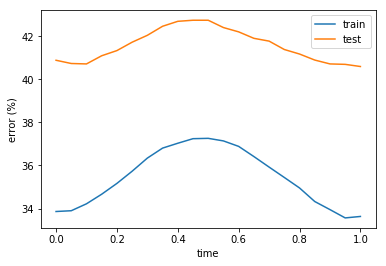

In [17]:
plt.plot(time, path_trl['train'], label='train')
plt.plot(time, path_trl['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

In [18]:
stat_prl = get_stat(PointFinderTransportation, model_name, architecture, t=0.5, method='lin_connect',
             beg_ind=1, end_ind=7)


 17%|█▋        | 1/6 [00:07<00:36,  7.25s/it]

train results {'nll': 1.1306275899124145, 'loss': 1.1306275899124145, 'accuracy': 62.396}
test results {'nll': 1.370669333076477, 'loss': 1.370669333076477, 'accuracy': 56.44}


 33%|███▎      | 2/6 [00:14<00:29,  7.27s/it]

train results {'nll': 1.1386494123840332, 'loss': 1.1386494123840332, 'accuracy': 62.2}
test results {'nll': 1.3739460319519043, 'loss': 1.3739460319519043, 'accuracy': 57.13}


 50%|█████     | 3/6 [00:21<00:21,  7.30s/it]

train results {'nll': 1.1288891778945922, 'loss': 1.1288891778945922, 'accuracy': 62.738}
test results {'nll': 1.3723571796417235, 'loss': 1.3723571796417235, 'accuracy': 57.25}


 67%|██████▋   | 4/6 [00:29<00:14,  7.34s/it]

train results {'nll': 1.121072514076233, 'loss': 1.121072514076233, 'accuracy': 62.472}
test results {'nll': 1.3733014923095703, 'loss': 1.3733014923095703, 'accuracy': 57.08}


 83%|████████▎ | 5/6 [00:36<00:07,  7.36s/it]

train results {'nll': 1.1616282735443115, 'loss': 1.1616282735443115, 'accuracy': 61.708}
test results {'nll': 1.4086247882843017, 'loss': 1.4086247882843017, 'accuracy': 56.15}


100%|██████████| 6/6 [00:44<00:00,  7.39s/it]

train results {'nll': 1.1581262199783324, 'loss': 1.1581262199783324, 'accuracy': 61.258}
test results {'nll': 1.3931721284866334, 'loss': 1.3931721284866334, 'accuracy': 56.17}


In [19]:
get_mean_svd(stat_prl)

(62.12866666666667, 0.5001235402933512, 56.703333333333326, 0.4623731057153835)

In [20]:
stat_zero = test_zeroing(PointFinderTransportation, model_name, architecture, beg_ind=1, end_ind=7)

  0%|          | 0/6 [00:00<?, ?it/s]/home/ivan/dnn-mode-connectivity/point_finders.py:315: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list(model_sampled.parameters())[-1].data.copy_(torch.tensor(B))
 17%|█▋        | 1/6 [00:07<00:36,  7.33s/it]

train results {'nll': 1.013846732597351, 'loss': 1.013846732597351, 'accuracy': 66.108}
test results {'nll': 1.3008504135131835, 'loss': 1.3008504135131835, 'accuracy': 59.48}


/home/ivan/dnn-mode-connectivity/point_finders.py:315: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list(model_sampled.parameters())[-1].data.copy_(torch.tensor(B))
 33%|███▎      | 2/6 [00:14<00:29,  7.31s/it]

train results {'nll': 1.023069288520813, 'loss': 1.023069288520813, 'accuracy': 66.102}
test results {'nll': 1.3266697511672974, 'loss': 1.3266697511672974, 'accuracy': 59.15}


/home/ivan/dnn-mode-connectivity/point_finders.py:315: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list(model_sampled.parameters())[-1].data.copy_(torch.tensor(B))
 50%|█████     | 3/6 [00:21<00:21,  7.29s/it]

train results {'nll': 1.0160322248649598, 'loss': 1.0160322248649598, 'accuracy': 66.362}
test results {'nll': 1.3176700359344482, 'loss': 1.3176700359344482, 'accuracy': 59.34}


/home/ivan/dnn-mode-connectivity/point_finders.py:315: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list(model_sampled.parameters())[-1].data.copy_(torch.tensor(B))
 67%|██████▋   | 4/6 [00:29<00:14,  7.28s/it]

train results {'nll': 1.0061186195755005, 'loss': 1.0061186195755005, 'accuracy': 66.372}
test results {'nll': 1.3123150671005248, 'loss': 1.3123150671005248, 'accuracy': 59.0}


/home/ivan/dnn-mode-connectivity/point_finders.py:315: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list(model_sampled.parameters())[-1].data.copy_(torch.tensor(B))
 83%|████████▎ | 5/6 [00:36<00:07,  7.29s/it]

train results {'nll': 1.0141219844818115, 'loss': 1.0141219844818115, 'accuracy': 66.092}
test results {'nll': 1.3102498769760131, 'loss': 1.3102498769760131, 'accuracy': 59.44}


/home/ivan/dnn-mode-connectivity/point_finders.py:315: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list(model_sampled.parameters())[-1].data.copy_(torch.tensor(B))
100%|██████████| 6/6 [00:43<00:00,  7.32s/it]

train results {'nll': 1.0173715712165832, 'loss': 1.0173715712165832, 'accuracy': 66.114}
test results {'nll': 1.3179269365310669, 'loss': 1.3179269365310669, 'accuracy': 58.85}


In [21]:
get_mean_svd(stat_zero)

(66.19166666666666, 0.12419026621366755, 59.21, 0.23094010767584933)

In [15]:
class PointFinderByOne(PointFinderWithBias):
    def __init__(self, model1, model2, architecture):
        super().__init__(model1, model2, architecture)

    def find_point(self, t, N, method='arc_connect'):
        assert 0 <= t <= 1, 't must be between 0 and 1'
        weights_model_new = getattr(Connector(self.weights_model1[N:N+1], self.weights_model2[N:N+1]), method)(t=t)[1]
        weights_model_new = list(self.weights_model2)[:N] + list(weights_model_new) + list(self.weights_model1[N+1:])
        B = self.get_b(self.model1, self.model2)
        B = getattr(Connector(B[:1], B[1:]), method)(t=t)[1]
        m = self.get_model_from_weights(weights_model_new, B[0], self.architecture)
        m.cuda();
        res = test_model(m, loaders, cuda=True)
        out = {'train': res[0]['accuracy'], 'test': res[1]['accuracy']}

        return out

In [16]:
pfb = PointFinder(model1, model2, architecture)

In [74]:
stat_wb = get_stat(PointFinderWithBias, model_name, architecture, t=0.5,
                  beg_ind=1, end_ind=7)

 17%|█▋        | 1/6 [00:12<01:03, 12.62s/it]

train results {'nll': 2.380592138748169, 'loss': 2.380592138748169, 'accuracy': 44.456}
test results {'nll': 2.5921855487823486, 'loss': 2.5921855487823486, 'accuracy': 42.47}


 33%|███▎      | 2/6 [00:25<00:50, 12.62s/it]

train results {'nll': 2.435529772491455, 'loss': 2.435529772491455, 'accuracy': 42.942}
test results {'nll': 2.646166815185547, 'loss': 2.646166815185547, 'accuracy': 40.99}


 50%|█████     | 3/6 [00:37<00:37, 12.61s/it]

train results {'nll': 2.4799481664276124, 'loss': 2.4799481664276124, 'accuracy': 42.122}
test results {'nll': 2.6905567951202394, 'loss': 2.6905567951202394, 'accuracy': 39.89}


 67%|██████▋   | 4/6 [00:50<00:25, 12.61s/it]

train results {'nll': 2.368421145019531, 'loss': 2.368421145019531, 'accuracy': 44.754}
test results {'nll': 2.5906559658050536, 'loss': 2.5906559658050536, 'accuracy': 41.68}


 83%|████████▎ | 5/6 [01:03<00:12, 12.61s/it]

train results {'nll': 2.3230034755706788, 'loss': 2.3230034755706788, 'accuracy': 42.938}
test results {'nll': 2.559454104614258, 'loss': 2.559454104614258, 'accuracy': 40.88}


100%|██████████| 6/6 [01:15<00:00, 12.63s/it]

train results {'nll': 2.3739052545166017, 'loss': 2.3739052545166017, 'accuracy': 43.376}
test results {'nll': 2.5974591327667236, 'loss': 2.5974591327667236, 'accuracy': 40.96}


In [75]:
get_mean_svd(stat_wb)

(43.43133333333333, 0.9128370914656981, 41.145, 0.7900791099630459)

In [76]:
stat_wbl = get_stat(PointFinderWithBias, model_name, architecture, t=0.5, method='lin_connect',
                  beg_ind=1, end_ind=7)

 17%|█▋        | 1/6 [00:12<01:03, 12.60s/it]

train results {'nll': 1.9666611227035522, 'loss': 1.9666611227035522, 'accuracy': 41.488}
test results {'nll': 2.0515497386932373, 'loss': 2.0515497386932373, 'accuracy': 39.7}


 33%|███▎      | 2/6 [00:25<00:50, 12.58s/it]

train results {'nll': 1.9367993900680542, 'loss': 1.9367993900680542, 'accuracy': 40.474}
test results {'nll': 2.033670974731445, 'loss': 2.033670974731445, 'accuracy': 38.18}


 50%|█████     | 3/6 [00:37<00:37, 12.59s/it]

train results {'nll': 1.9625302530288695, 'loss': 1.9625302530288695, 'accuracy': 41.354}
test results {'nll': 2.049591414260864, 'loss': 2.049591414260864, 'accuracy': 39.31}


 67%|██████▋   | 4/6 [00:50<00:25, 12.60s/it]

train results {'nll': 1.9057716506958007, 'loss': 1.9057716506958007, 'accuracy': 41.692}
test results {'nll': 2.0193163990020753, 'loss': 2.0193163990020753, 'accuracy': 39.22}


 83%|████████▎ | 5/6 [01:02<00:12, 12.60s/it]

train results {'nll': 1.9659310943603516, 'loss': 1.9659310943603516, 'accuracy': 40.222}
test results {'nll': 2.065386840057373, 'loss': 2.065386840057373, 'accuracy': 37.99}


100%|██████████| 6/6 [01:15<00:00, 12.59s/it]

train results {'nll': 1.8959565802764893, 'loss': 1.8959565802764893, 'accuracy': 41.454}
test results {'nll': 1.991972181892395, 'loss': 1.991972181892395, 'accuracy': 39.52}


In [77]:
get_mean_svd(stat_wbl)

(41.114, 0.5556413711498934, 38.98666666666667, 0.6578162526285155)

# End Point Stat

In [ ]:
stat = get_end_point_stat(architecture, model_name, beg_ind=1, end_ind=8)

 14%|█▍        | 1/7 [00:18<01:51, 18.63s/it]

train results {'nll': 0.025799275891780854, 'loss': 0.025799275891780854, 'accuracy': 99.366}
test results {'nll': 2.340163063430786, 'loss': 2.340163063430786, 'accuracy': 61.71}


 29%|██▊       | 2/7 [00:36<01:32, 18.54s/it]

train results {'nll': 0.022805038956403734, 'loss': 0.022805038956403734, 'accuracy': 99.446}
test results {'nll': 2.369862328720093, 'loss': 2.369862328720093, 'accuracy': 61.49}


 43%|████▎     | 3/7 [00:56<01:15, 18.77s/it]

train results {'nll': 0.02311081454396248, 'loss': 0.02311081454396248, 'accuracy': 99.476}
test results {'nll': 2.3554563179016115, 'loss': 2.3554563179016115, 'accuracy': 61.85}


 57%|█████▋    | 4/7 [01:14<00:56, 18.70s/it]

train results {'nll': 0.024681506884694098, 'loss': 0.024681506884694098, 'accuracy': 99.342}
test results {'nll': 2.369380573654175, 'loss': 2.369380573654175, 'accuracy': 61.53}


In [12]:
get_mean_svd(stat)

(99.42228571428572,
 0.05293045109444276,
 61.72428571428571,
 0.21029619539097197)

# Simultaneous Connection Stat

In [ ]:
pf = PointFinderSimultaneous(model1, model2, architecture)

In [ ]:
pf.find_point(0.5)

In [ ]:
stat_s = get_stat(PointFinderSimultaneous, model_name, architecture, t=0.5,
                  beg_ind=1, end_ind=7)
get_mean_svd(stat_s)

In [14]:
get_mean_svd(stat_s)

(43.066, 1.9372585440943753, 37.92333333333333, 1.8489786970709587)

In [16]:
stat_sl = get_stat(PointFinderSimultaneous, model_name, architecture, 
                  beg_ind=1, end_ind=7, method='lin_connect')
get_mean_svd(stat_sl)


 17%|█▋        | 1/6 [00:20<01:41, 20.23s/it]

train results {'nll': 2.1606676138305665, 'loss': 2.1606676138305665, 'accuracy': 38.052}
test results {'nll': 2.1791792755126953, 'loss': 2.1791792755126953, 'accuracy': 33.61}



 33%|███▎      | 2/6 [00:40<01:21, 20.30s/it]

train results {'nll': 2.1705334020233154, 'loss': 2.1705334020233154, 'accuracy': 30.958}
test results {'nll': 2.1869637825012207, 'loss': 2.1869637825012207, 'accuracy': 26.98}



 50%|█████     | 3/6 [01:00<01:00, 20.26s/it]

train results {'nll': 2.156970229110718, 'loss': 2.156970229110718, 'accuracy': 33.708}
test results {'nll': 2.174539278793335, 'loss': 2.174539278793335, 'accuracy': 29.42}



 67%|██████▋   | 4/6 [01:22<00:41, 20.71s/it]

train results {'nll': 2.158530164489746, 'loss': 2.158530164489746, 'accuracy': 36.93}
test results {'nll': 2.174554136657715, 'loss': 2.174554136657715, 'accuracy': 32.79}



 83%|████████▎ | 5/6 [01:43<00:20, 20.71s/it]

train results {'nll': 2.141670345001221, 'loss': 2.141670345001221, 'accuracy': 36.414}
test results {'nll': 2.1602546333312986, 'loss': 2.1602546333312986, 'accuracy': 31.41}



100%|██████████| 6/6 [02:04<00:00, 20.70s/it]


train results {'nll': 2.146985368270874, 'loss': 2.146985368270874, 'accuracy': 33.994}
test results {'nll': 2.163372517776489, 'loss': 2.163372517776489, 'accuracy': 30.0}


(35.00933333333334, 2.3824896408775613, 30.701666666666668, 2.210093638036381)

In [17]:
get_mean_svd(stat_sl)

(35.00933333333334, 2.3824896408775613, 30.701666666666668, 2.210093638036381)

# Butterfly Stat

In [6]:
pf_b = PointFinderStepWiseButterfly(model1, model2, architecture)

  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps


  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps


100%|██████████| 3/3 [00:21<00:00,  8.48s/it]
0it [00:00, ?it/s]

adjusting weights


3it [07:43, 212.26s/it]


In [13]:
time = np.linspace(0, depth, depth*6+1)
time

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        , 1.16666667, 1.33333333, 1.5       ,
       1.66666667, 1.83333333, 2.        , 2.16666667, 2.33333333,
       2.5       , 2.66666667, 2.83333333, 3.        , 3.16666667,
       3.33333333, 3.5       , 3.66666667, 3.83333333, 4.        ,
       4.16666667, 4.33333333, 4.5       , 4.66666667, 4.83333333,
       5.        ])

In [14]:
path_b = find_path(time, pf_b, method='arc_connect')

  3%|▎         | 1/31 [00:20<10:08, 20.27s/it]

train results {'nll': 0.02311081440448761, 'loss': 0.02311081440448761, 'accuracy': 99.476}
test results {'nll': 2.3554563610076906, 'loss': 2.3554563610076906, 'accuracy': 61.85}


  6%|▋         | 2/31 [00:42<10:02, 20.77s/it]

train results {'nll': 0.0346201055085659, 'loss': 0.0346201055085659, 'accuracy': 99.118}
test results {'nll': 2.355057799911499, 'loss': 2.355057799911499, 'accuracy': 61.15}


 10%|▉         | 3/31 [01:01<09:33, 20.48s/it]

train results {'nll': 0.09705775912284852, 'loss': 0.09705775912284852, 'accuracy': 96.842}
test results {'nll': 2.429749712753296, 'loss': 2.429749712753296, 'accuracy': 59.21}


 13%|█▎        | 4/31 [01:22<09:16, 20.63s/it]

train results {'nll': 0.1613047597026825, 'loss': 0.1613047597026825, 'accuracy': 94.53}
test results {'nll': 2.4986160202026366, 'loss': 2.4986160202026366, 'accuracy': 58.18}


 16%|█▌        | 5/31 [01:44<09:02, 20.85s/it]

train results {'nll': 0.10556922871351242, 'loss': 0.10556922871351242, 'accuracy': 96.418}
test results {'nll': 2.446371557998657, 'loss': 2.446371557998657, 'accuracy': 59.37}


 19%|█▉        | 6/31 [02:04<08:36, 20.66s/it]

train results {'nll': 0.03920828018784523, 'loss': 0.03920828018784523, 'accuracy': 98.926}
test results {'nll': 2.371749269104004, 'loss': 2.371749269104004, 'accuracy': 61.09}


 23%|██▎       | 7/31 [02:26<08:21, 20.90s/it]

train results {'nll': 0.025912263960838317, 'loss': 0.025912263960838317, 'accuracy': 99.386}
test results {'nll': 2.3626223724365234, 'loss': 2.3626223724365234, 'accuracy': 61.72}


 26%|██▌       | 8/31 [02:46<07:58, 20.79s/it]

train results {'nll': 0.08407561532020569, 'loss': 0.08407561532020569, 'accuracy': 97.18}
test results {'nll': 2.4180985580444334, 'loss': 2.4180985580444334, 'accuracy': 60.59}


 29%|██▉       | 9/31 [03:06<07:29, 20.42s/it]

train results {'nll': 0.5000852962112426, 'loss': 0.5000852962112426, 'accuracy': 84.768}
test results {'nll': 2.6560116397857665, 'loss': 2.6560116397857665, 'accuracy': 57.26}


 32%|███▏      | 10/31 [03:25<07:03, 20.16s/it]

train results {'nll': 0.9723580808067321, 'loss': 0.9723580808067321, 'accuracy': 75.454}
test results {'nll': 2.8543504409790037, 'loss': 2.8543504409790037, 'accuracy': 55.34}


 35%|███▌      | 11/31 [03:45<06:38, 19.94s/it]

train results {'nll': 0.7549392844581604, 'loss': 0.7549392844581604, 'accuracy': 79.118}
test results {'nll': 2.667583271789551, 'loss': 2.667583271789551, 'accuracy': 56.84}


 39%|███▊      | 12/31 [04:04<06:16, 19.84s/it]

train results {'nll': 0.284160764093399, 'loss': 0.284160764093399, 'accuracy': 90.196}
test results {'nll': 2.381463835144043, 'loss': 2.381463835144043, 'accuracy': 59.93}


 42%|████▏     | 13/31 [04:24<05:56, 19.83s/it]

train results {'nll': 0.14499025668621063, 'loss': 0.14499025668621063, 'accuracy': 94.862}
test results {'nll': 2.271600431442261, 'loss': 2.271600431442261, 'accuracy': 61.66}


 45%|████▌     | 14/31 [04:44<05:36, 19.81s/it]

train results {'nll': 0.3119721153640747, 'loss': 0.3119721153640747, 'accuracy': 89.516}
test results {'nll': 2.407923331451416, 'loss': 2.407923331451416, 'accuracy': 60.18}


 48%|████▊     | 15/31 [05:02<05:10, 19.43s/it]

train results {'nll': 0.8591339293289184, 'loss': 0.8591339293289184, 'accuracy': 77.45}
test results {'nll': 2.633820461654663, 'loss': 2.633820461654663, 'accuracy': 57.1}


 52%|█████▏    | 16/31 [05:22<04:53, 19.56s/it]

train results {'nll': 1.2360605472564696, 'loss': 1.2360605472564696, 'accuracy': 71.57}
test results {'nll': 2.753880615234375, 'loss': 2.753880615234375, 'accuracy': 55.32}


 55%|█████▍    | 17/31 [05:42<04:36, 19.77s/it]

train results {'nll': 0.9473435217666626, 'loss': 0.9473435217666626, 'accuracy': 75.926}
test results {'nll': 2.5618952545166014, 'loss': 2.5618952545166014, 'accuracy': 57.54}


 58%|█████▊    | 18/31 [06:03<04:19, 19.96s/it]

train results {'nll': 0.418967825422287, 'loss': 0.418967825422287, 'accuracy': 86.528}
test results {'nll': 2.2669828937530516, 'loss': 2.2669828937530516, 'accuracy': 61.07}


 61%|██████▏   | 19/31 [06:23<04:01, 20.13s/it]

train results {'nll': 0.2234483252429962, 'loss': 0.2234483252429962, 'accuracy': 91.974}
test results {'nll': 2.1622446655273437, 'loss': 2.1622446655273437, 'accuracy': 62.52}


 65%|██████▍   | 20/31 [06:44<03:44, 20.42s/it]

train results {'nll': 0.22603630239963532, 'loss': 0.22603630239963532, 'accuracy': 91.996}
test results {'nll': 2.1740310009002686, 'loss': 2.1740310009002686, 'accuracy': 62.24}


 68%|██████▊   | 21/31 [07:05<03:24, 20.47s/it]

train results {'nll': 0.19430615143299101, 'loss': 0.19430615143299101, 'accuracy': 93.134}
test results {'nll': 2.19307737159729, 'loss': 2.19307737159729, 'accuracy': 62.02}


 71%|███████   | 22/31 [07:24<03:00, 20.05s/it]

train results {'nll': 0.12041250507593156, 'loss': 0.12041250507593156, 'accuracy': 95.864}
test results {'nll': 2.228422426986694, 'loss': 2.228422426986694, 'accuracy': 61.64}


 74%|███████▍  | 23/31 [07:45<02:41, 20.20s/it]

train results {'nll': 0.05622499491453171, 'loss': 0.05622499491453171, 'accuracy': 98.328}
test results {'nll': 2.280330142211914, 'loss': 2.280330142211914, 'accuracy': 61.71}


 77%|███████▋  | 24/31 [08:04<02:20, 20.01s/it]

train results {'nll': 0.029780661680698393, 'loss': 0.029780661680698393, 'accuracy': 99.254}
test results {'nll': 2.338973477554321, 'loss': 2.338973477554321, 'accuracy': 61.46}


 81%|████████  | 25/31 [08:24<01:59, 19.97s/it]

train results {'nll': 0.02468150682747364, 'loss': 0.02468150682747364, 'accuracy': 99.342}
test results {'nll': 2.369380598068237, 'loss': 2.369380598068237, 'accuracy': 61.53}


 84%|████████▍ | 26/31 [08:43<01:38, 19.74s/it]

train results {'nll': 0.02468150682747364, 'loss': 0.02468150682747364, 'accuracy': 99.342}
test results {'nll': 2.369380598068237, 'loss': 2.369380598068237, 'accuracy': 61.53}


 87%|████████▋ | 27/31 [09:04<01:20, 20.17s/it]

train results {'nll': 0.02468150682747364, 'loss': 0.02468150682747364, 'accuracy': 99.342}
test results {'nll': 2.369380598068237, 'loss': 2.369380598068237, 'accuracy': 61.53}


 90%|█████████ | 28/31 [09:23<00:59, 19.81s/it]

train results {'nll': 0.02468150682747364, 'loss': 0.02468150682747364, 'accuracy': 99.342}
test results {'nll': 2.369380598068237, 'loss': 2.369380598068237, 'accuracy': 61.53}


 94%|█████████▎| 29/31 [09:43<00:39, 19.65s/it]

train results {'nll': 0.02468150682747364, 'loss': 0.02468150682747364, 'accuracy': 99.342}
test results {'nll': 2.369380598068237, 'loss': 2.369380598068237, 'accuracy': 61.53}


 97%|█████████▋| 30/31 [10:02<00:19, 19.49s/it]

train results {'nll': 0.02468150682747364, 'loss': 0.02468150682747364, 'accuracy': 99.342}
test results {'nll': 2.369380598068237, 'loss': 2.369380598068237, 'accuracy': 61.53}


100%|██████████| 31/31 [10:22<00:00, 19.78s/it]

train results {'nll': 0.02468150682747364, 'loss': 0.02468150682747364, 'accuracy': 99.342}
test results {'nll': 2.369380598068237, 'loss': 2.369380598068237, 'accuracy': 61.53}


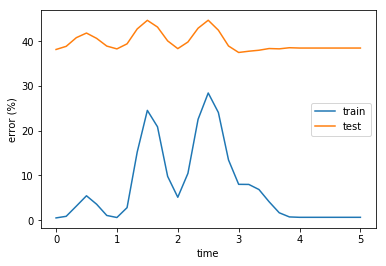

In [15]:
plt.plot(time, path_b['train'], label='train')
plt.plot(time, path_b['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

In [ ]:
stat_b = get_stat(PointFinderStepWiseButterfly, model_name, architecture, t=2.5,
                  beg_ind=1, end_ind=7)

  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 3/3 [00:20<00:00,  7.97s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 3/3 [00:23<00:00,  9.11s/it]

0it [00:00, ?it/s]

adjusting weights



1it [10:02, 602.75s/it]
2it [10:44, 434.39s/it]
3it [10:58, 308.19s/it]
 17%|█▋        | 1/6 [12:02<1:00:10, 722.16s/it]

train results {'nll': 1.215883578414917, 'loss': 1.215883578414917, 'accuracy': 71.45}
test results {'nll': 2.7456366962432863, 'loss': 2.7456366962432863, 'accuracy': 55.17}



  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 3/3 [00:20<00:00,  8.17s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 3/3 [00:20<00:00,  7.82s/it]

0it [00:00, ?it/s]

adjusting weights



1it [06:55, 415.97s/it]
2it [07:40, 304.62s/it]
3it [07:57, 218.31s/it]
 33%|███▎      | 2/6 [21:02<44:30, 667.59s/it]  

train results {'nll': 1.2504998838424684, 'loss': 1.2504998838424684, 'accuracy': 70.806}
test results {'nll': 2.7852711139678954, 'loss': 2.7852711139678954, 'accuracy': 55.1}



  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 3/3 [00:20<00:00,  8.15s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 3/3 [00:20<00:00,  8.08s/it]

0it [00:00, ?it/s]

adjusting weights



1it [06:52, 412.92s/it]
2it [07:39, 303.05s/it]
3it [07:51, 215.70s/it]
 50%|█████     | 3/6 [29:57<31:23, 627.84s/it]

train results {'nll': 1.2360605472564696, 'loss': 1.2360605472564696, 'accuracy': 71.57}
test results {'nll': 2.753880615234375, 'loss': 2.753880615234375, 'accuracy': 55.32}



  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 3/3 [00:21<00:00,  8.30s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 3/3 [00:20<00:00,  7.89s/it]

0it [00:00, ?it/s]

adjusting weights



1it [06:43, 403.24s/it]
2it [07:24, 294.60s/it]
3it [07:39, 210.74s/it]
 67%|██████▋   | 4/6 [38:39<19:52, 596.09s/it]

train results {'nll': 1.3182989444351196, 'loss': 1.3182989444351196, 'accuracy': 70.342}
test results {'nll': 2.8603381500244143, 'loss': 2.8603381500244143, 'accuracy': 55.42}



  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 3/3 [00:21<00:00,  8.63s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 3/3 [00:20<00:00,  8.05s/it]

0it [00:00, ?it/s]

adjusting weights



1it [06:55, 415.87s/it]
2it [07:37, 303.51s/it]
3it [07:54, 217.50s/it]
 83%|████████▎ | 5/6 [47:37<09:38, 578.58s/it]

train results {'nll': 1.2177199729919435, 'loss': 1.2177199729919435, 'accuracy': 71.726}
test results {'nll': 2.72945258140564, 'loss': 2.72945258140564, 'accuracy': 55.96}



  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 3/3 [00:20<00:00,  7.90s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

finding feature maps



100%|██████████| 3/3 [00:21<00:00,  8.51s/it]

0it [00:00, ?it/s]

adjusting weights



1it [06:47, 407.83s/it]
2it [07:34, 299.46s/it]
3it [07:50, 214.34s/it]


In [ ]:
get_mean_svd(stat_b)

In [ ]:
stat_bl = get_stat(PointFinderStepWiseButterfly, model_name, architecture, t=depth-0.5,
                  beg_ind=1, end_ind=7, method='lin_connect')

In [ ]:
get_mean_svd(stat_bl)

# Inverse Stat

In [ ]:
pf_inv = PointFinderStepWiseInverse(model1, model2, architecture) 

In [ ]:
path_i = find_path(time, pf_inv, method='arc_connect')

In [ ]:
plt.plot(time, path_i['train'], label='train')
plt.plot(time, path_i['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

In [ ]:
stat_i = get_stat(PointFinderStepWiseInverse, model_name, architecture, t=depth-1.5,
                  beg_ind=1, end_ind=7)

In [ ]:
stat_il = get_stat(PointFinderStepWiseInverse, model_name, architecture, t=depth-1.5,
                  beg_ind=1, end_ind=7, method='lin_connect')

# Path Visualization 

In [1]:
# time = np.linspace(0, 2, 9)

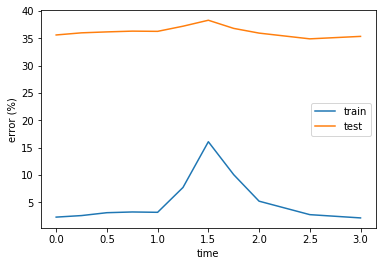

In [138]:
plt.plot(time, path['train'], label='train')
plt.plot(time, path['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

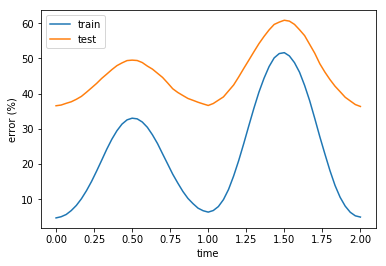

In [37]:
plt.plot(time, path_l['train'], label='train')
plt.plot(time, path_l['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

# Count statistic in the fixed point

In [46]:
arcbutterfly = get_stat(PointFinder, t=1.5, method='arc_connect')


100%|██████████| 6/6 [12:07<00:00, 121.25s/it]


In [49]:
arcbutterfly

{'test': [48.77, 50.42, 49.46, 51.32, 49.09, 48.82],
 'train': [59.931999999999995,
  60.978,
  60.397999999999996,
  62.21600000000001,
  60.01,
  60.124]}

In [53]:
get_mean_svd(arcbutterfly)

(60.60966666666667, 0.7974420912448094, 49.64666666666667, 0.930477774527091)

In [54]:
linbutterfly = get_stat(PointFinder, t=1.5, method='lin_connect')


100%|██████████| 6/6 [12:06<00:00, 121.03s/it]


In [55]:
linbutterfly

{'test': [36.93, 39.17, 39.379999999999995, 39.21, 38.12, 37.75],
 'train': [46.738,
  48.374,
  48.087999999999994,
  49.036,
  47.355999999999995,
  47.326]}

In [56]:
get_mean_svd(linbutterfly)

(47.81966666666667, 0.7623922146040647, 38.42666666666667, 0.9006417465094294)

In [57]:
linpseudo = get_stat(PointFinderInverse, t=1.5, method='lin_connect')


 17%|█▋        | 1/6 [02:26<12:13, 146.64s/it]

1.5 {'train': 61.026, 'test': 51.839999999999996}



 33%|███▎      | 2/6 [04:53<09:46, 146.74s/it]

1.5 {'train': 60.948, 'test': 51.64}



 50%|█████     | 3/6 [07:20<07:20, 146.78s/it]

1.5 {'train': 60.784000000000006, 'test': 51.68000000000001}



 67%|██████▋   | 4/6 [09:47<04:53, 146.83s/it]

1.5 {'train': 61.419999999999995, 'test': 52.18000000000001}



 83%|████████▎ | 5/6 [12:14<02:26, 146.83s/it]

1.5 {'train': 60.846000000000004, 'test': 52.23}



100%|██████████| 6/6 [14:41<00:00, 146.84s/it]


1.5 {'train': 60.57599999999999, 'test': 51.68000000000001}


In [63]:
linpseudo

{'test': [51.839999999999996,
  51.64,
  51.68000000000001,
  52.18000000000001,
  52.23,
  51.68000000000001],
 'train': [61.026,
  60.948,
  60.784000000000006,
  61.419999999999995,
  60.846000000000004,
  60.57599999999999]}

In [64]:
get_mean_svd(linpseudo)

(60.93333333333334, 0.2592493437257302, 51.875, 0.2420571557848809)